In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ip-network-traffic-flows-labeled-with-87-apps/Dataset-Unicauca-Version2-87Atts.csv


In [2]:
# importing the required libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

In [3]:
# importing algorithms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

sc = StandardScaler()

## Reading the data from csv file

In [4]:
data = pd.read_csv("/kaggle/input/ip-network-traffic-flows-labeled-with-87-apps/Dataset-Unicauca-Version2-87Atts.csv")
data.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


In [5]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 3577296
Number of Columns: 87


## Under Sampling

Number of Unique Application Names:  78


Text(0, 0.5, 'Frequency')

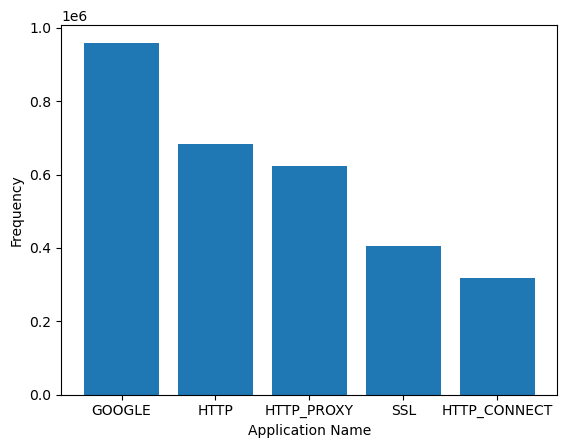

In [6]:
# Graph of Protocol Name vs Frequency
freq_protocol = data['ProtocolName'].value_counts()
# sns.histplot(freq_protocol.values())
application_name = []
frequency_count = []
for key, value in freq_protocol.items():
    application_name.append(key)
    frequency_count.append(value)
    
print("Number of Unique Application Names: ", len(freq_protocol))    

# graph of top 5 application names
top_values = 5
plt.bar(application_name[:top_values], frequency_count[:top_values])
plt.xlabel("Application Name")
plt.ylabel("Frequency")

In [7]:
# filtering the classes which have more than 10000 rows (occurrences)

requiredProtocolName = []
for key, value in freq_protocol.items():
    if (value >= 10000):
        requiredProtocolName.append(key)

print(requiredProtocolName)

['GOOGLE', 'HTTP', 'HTTP_PROXY', 'SSL', 'HTTP_CONNECT', 'YOUTUBE', 'AMAZON', 'MICROSOFT', 'GMAIL', 'WINDOWS_UPDATE', 'SKYPE', 'FACEBOOK', 'DROPBOX', 'YAHOO', 'TWITTER', 'CLOUDFLARE', 'MSN']


In [8]:
# taking the random 10000 data from the requiredProtocolName
# and forming the dataset
listofDataFrames = []
for protocol in requiredProtocolName:
    listofDataFrames.append(pd.DataFrame(data[data['ProtocolName'] == protocol].sample(n = 10000)))

sampledData = pd.concat(listofDataFrames)
sampledData.shape

(170000, 87)

In [9]:
# taking random rows and shuffling the dataframe
data = sampledData.sample(frac=1, random_state=1).reset_index()

# remove the rows that contains NULL values
data.dropna(inplace=True)
data.dropna(axis='columns')
data.reset_index(drop=True, inplace=True)

# remove columns which contains zeroes in the data
data = data.loc[:, (data != 0).any(axis=0)]

In [10]:
print('Shape after removing rows with NULL Values')
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Shape after removing rows with NULL Values
Number of Rows: 170000
Number of Columns: 78


In [11]:
# converting the protocol name (target column) to required format (int)
# using LabelEncoder function from sklearn.preprocession library
encoder = LabelEncoder().fit(data['ProtocolName'])
data['ProtocolName'] = encoder.transform(data['ProtocolName'])
values = encoder.inverse_transform(data['ProtocolName'])
target_column = data['ProtocolName']

# mapping the encoded value
encoded_target_column = {}
for i in range(len(data['ProtocolName'])):
    encoded_target_column[data['ProtocolName'][i]] = values[i]

print(encoded_target_column)

{2: 'DROPBOX', 15: 'YAHOO', 13: 'TWITTER', 12: 'SSL', 4: 'GMAIL', 1: 'CLOUDFLARE', 3: 'FACEBOOK', 0: 'AMAZON', 8: 'HTTP_PROXY', 10: 'MSN', 7: 'HTTP_CONNECT', 11: 'SKYPE', 9: 'MICROSOFT', 5: 'GOOGLE', 6: 'HTTP', 14: 'WINDOWS_UPDATE', 16: 'YOUTUBE'}


In [12]:
# get all the column heads
data.columns

Index(['index', 'Flow.ID', 'Source.IP', 'Source.Port', 'Destination.IP',
       'Destination.Port', 'Protocol', 'Timestamp', 'Flow.Duration',
       'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min',
       'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std',
       'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min',
       'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max',
       'Flow.IAT.Min', 'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std',
       'Fwd.IAT.Max', 'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Header.Length', 'Bwd.Header.Length', 'Fwd.Packets.s',
       'Bwd.Packets.s', 'Min.Packet.Length', 'Max.Packet.Length',
       'Packet.Length.Mean', 'Packet.Length.Std', 'Packet.Length.Variance

In [13]:
# removing extra columns that are not useful for finding correlation
# axis = 1 because we need to drop the columns
# by default axis = 0 (drop the rows)
dataset = data.drop(['Flow.ID','Source.IP','Label', 'Timestamp','Destination.IP', 'Source.Port', 'Destination.Port', 'Protocol'], axis=1)

x_dataset = dataset.drop(['ProtocolName'], axis = 1)
y_dataset = dataset['ProtocolName']

# normal dataset
X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Correlation Matrix

In [14]:
# finding the correlation matrix
correlation_matrix = dataset.corr()
correlation_matrix.head()

,index,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Packet.Length.Max,Fwd.Packet.Length.Min,Fwd.Packet.Length.Mean,Fwd.Packet.Length.Std,...,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol,ProtocolName
index,1.000000,0.038856,0.004440,0.003990,0.007338,-0.022512,-0.008649,0.010968,0.005934,-0.006571,...,-0.011802,0.008392,-0.005309,-0.016000,0.039570,0.025510,0.041554,0.036173,0.019540,-0.050274
Flow.Duration,0.038856,1.000000,0.093880,0.097314,0.041240,0.094560,0.186577,0.050355,0.179621,0.155620,...,0.206017,0.232186,0.270262,0.134036,0.712828,0.474007,0.754806,0.641382,0.043942,-0.094032
Total.Fwd.Packets,0.004440,0.093880,1.000000,0.865578,0.783131,0.392394,0.211275,0.023859,0.116744,0.048709,...,0.107905,0.067238,0.112628,0.091092,-0.007040,0.006993,-0.003751,-0.009056,0.001307,0.020826
Total.Backward.Packets,0.003990,0.097314,0.865578,1.000000,0.556864,0.507913,0.152100,0.013278,0.072007,0.028834,...,0.117883,0.076148,0.125120,0.098702,-0.006466,0.010307,-0.002263,-0.009239,0.006869,0.031470
Total.Length.of.Fwd.Packets,0.007338,0.041240,0.783131,0.556864,1.000000,0.001454,0.244344,0.027688,0.156123,0.076023,...,0.028861,0.011894,0.027588,0.026788,-0.005147,-0.001007,-0.004685,-0.005194,-0.004172,-0.004734


[]

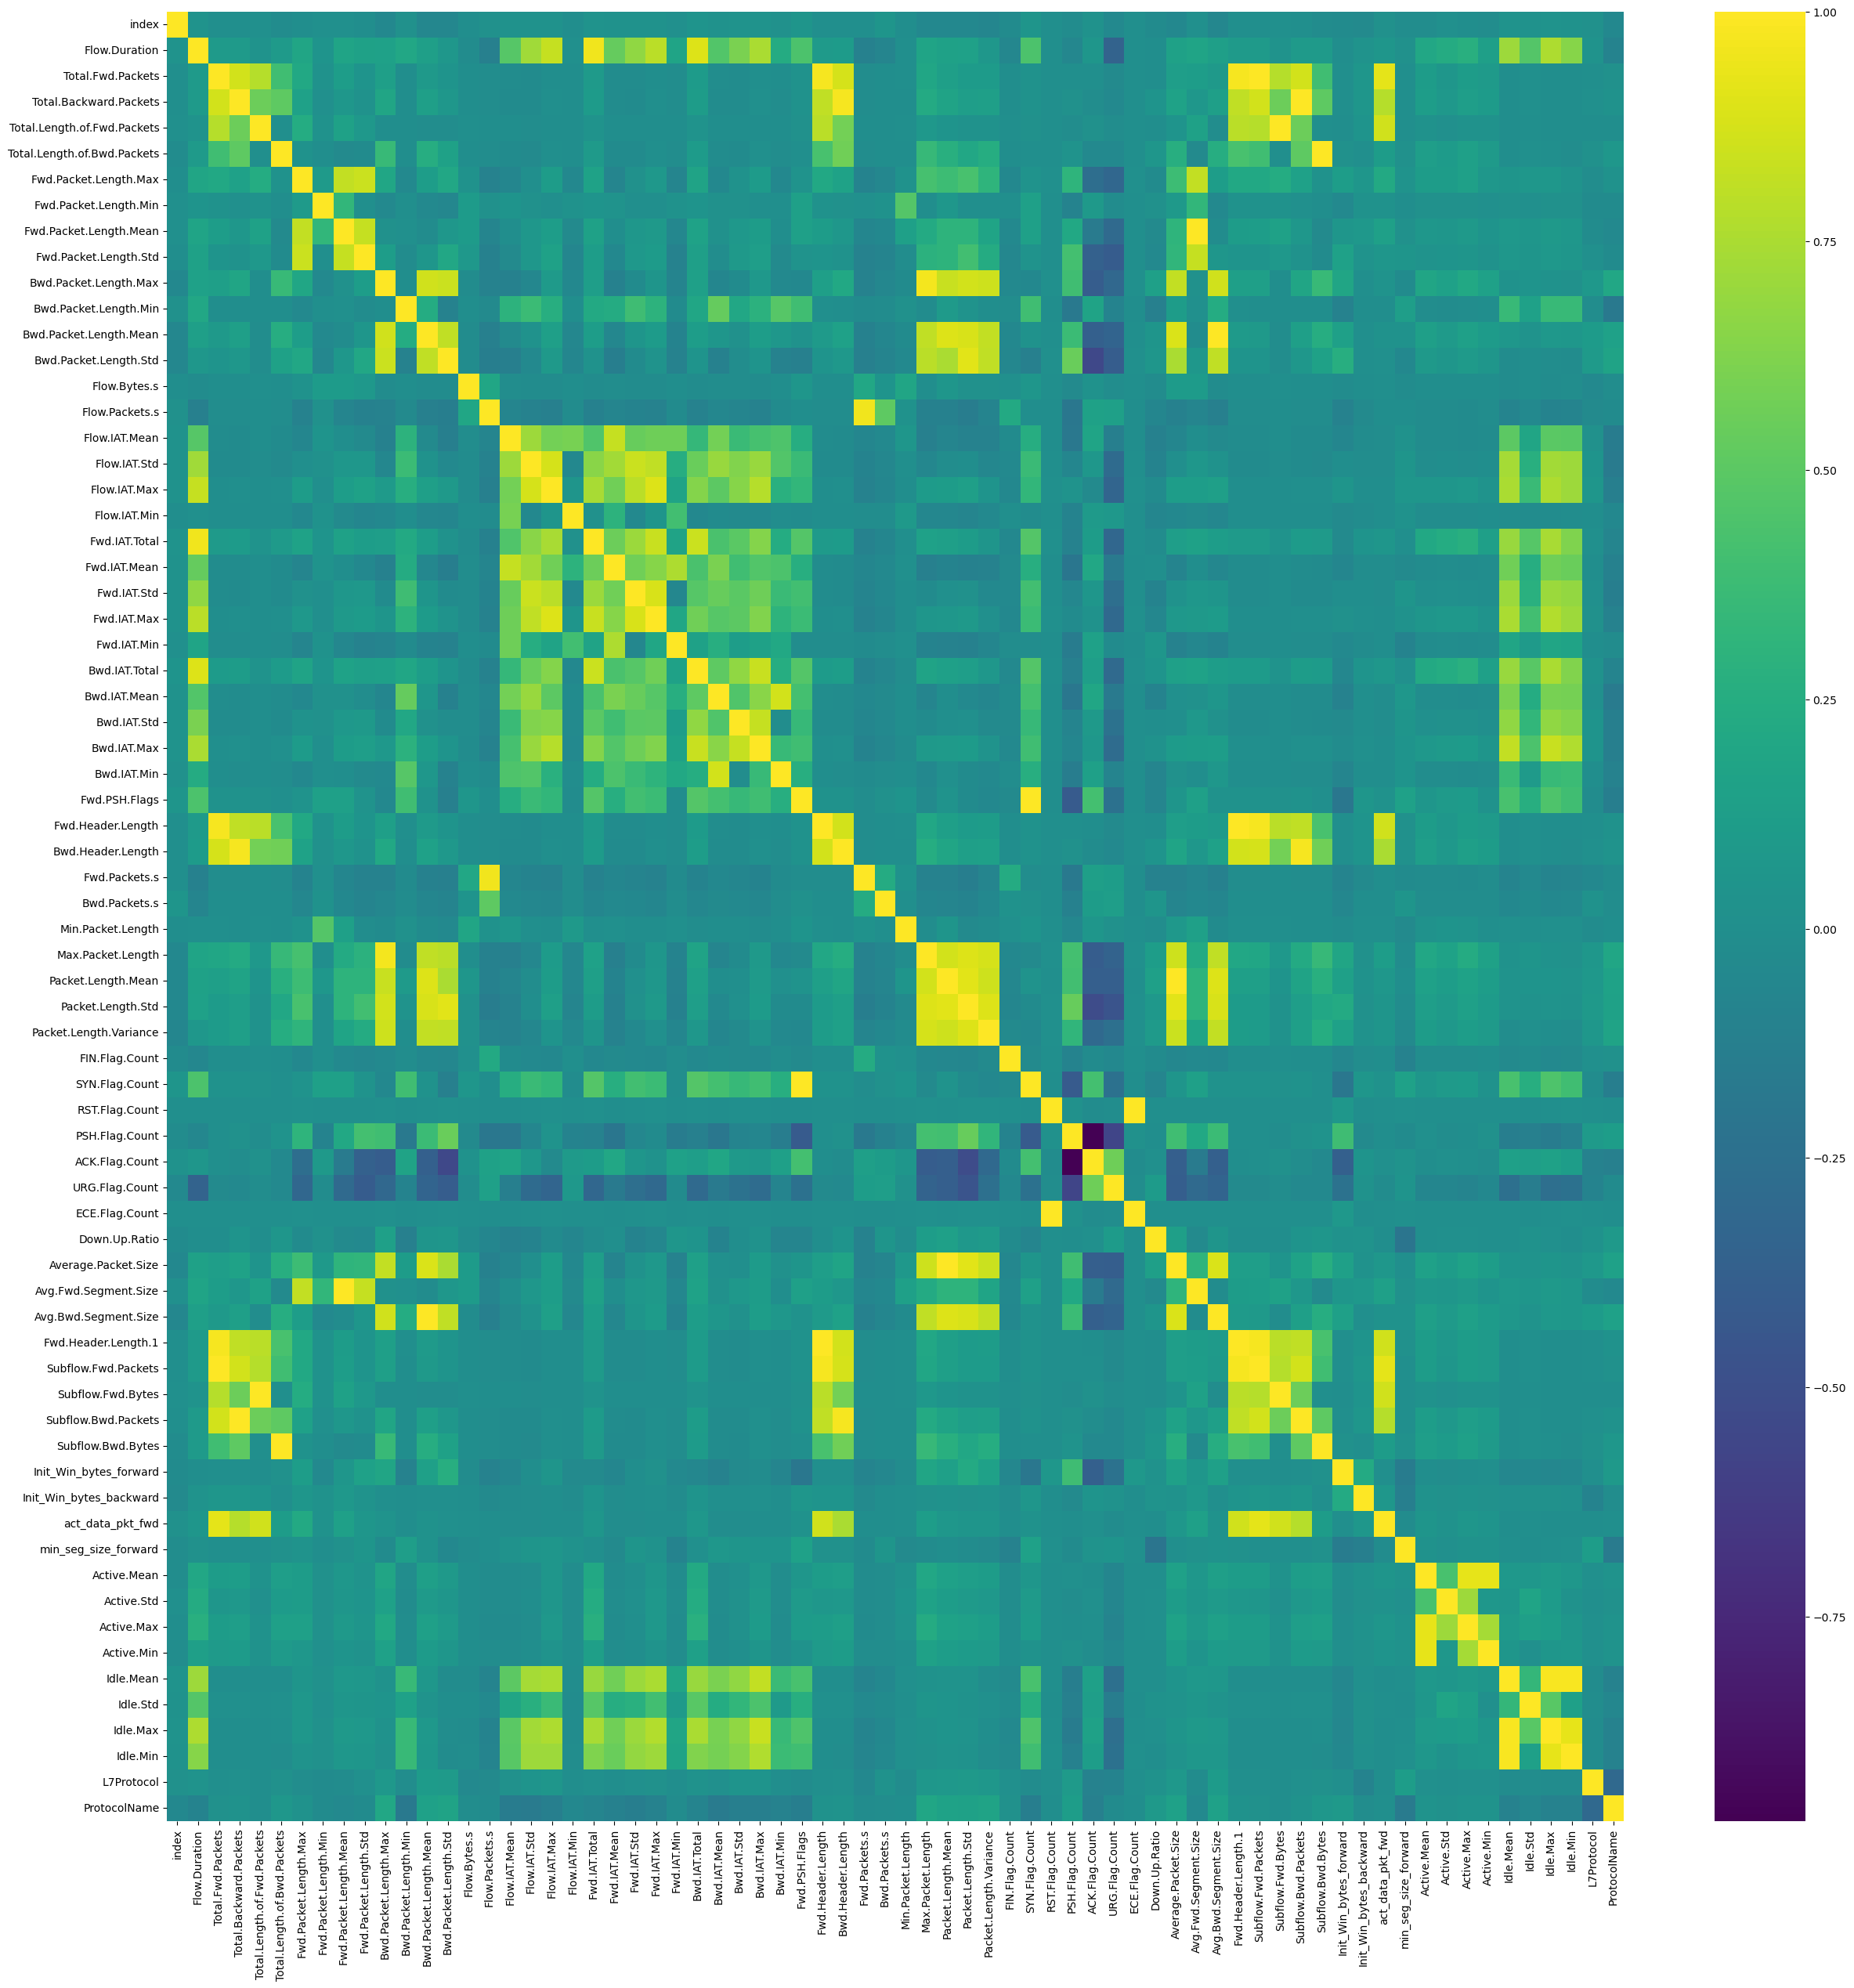

In [15]:
# plotting the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, cmap='viridis')
plt.plot()

## Feature Selection via Correlation Matrix

In [16]:
sorted_corr_matrix_protocolName = correlation_matrix['ProtocolName'].sort_values(ascending=False)
allKeys = list(sorted_corr_matrix_protocolName.keys())

# removing the target column
allKeys.remove('ProtocolName')

feature_map = {}

# removing the features which has less than 0.01 correlation
# and grouping the columns which have same correlation (rounding upto 2 decimal places)
for colName in allKeys:
    correlation = round(sorted_corr_matrix_protocolName[colName], 2)
    if (abs(correlation) >= 0.01):
        if correlation in feature_map:
            feature_map[correlation].append(colName)
        else:
            feature_map[correlation] = [colName]

print("Columns with absolute correlation greater than 0.01 with ProtocolName: \n")
print(feature_map)

Columns with absolute correlation greater than 0.01 with ProtocolName: 

{0.2: ['Bwd.Packet.Length.Max'], 0.19: ['Max.Packet.Length'], 0.17: ['Bwd.Packet.Length.Std', 'Packet.Length.Variance'], 0.16: ['Packet.Length.Mean', 'Packet.Length.Std'], 0.15: ['Bwd.Packet.Length.Mean', 'Avg.Bwd.Segment.Size', 'Average.Packet.Size'], 0.11: ['PSH.Flag.Count'], 0.09: ['Down.Up.Ratio', 'Init_Win_bytes_forward'], 0.07: ['Subflow.Bwd.Bytes', 'Total.Length.of.Bwd.Packets'], 0.04: ['Active.Mean', 'Active.Min', 'Bwd.Header.Length', 'Active.Max'], 0.03: ['Subflow.Bwd.Packets', 'Total.Backward.Packets', 'Fwd.Packet.Length.Max'], 0.02: ['Fwd.Header.Length', 'Fwd.Header.Length.1', 'Subflow.Fwd.Packets', 'Total.Fwd.Packets', 'Active.Std', 'FIN.Flag.Count'], -0.01: ['Init_Win_bytes_backward', 'Flow.Bytes.s'], -0.02: ['Bwd.Packets.s', 'Fwd.IAT.Min', 'Fwd.Packets.s'], -0.03: ['Fwd.Packet.Length.Std', 'Flow.Packets.s', 'Fwd.Packet.Length.Min', 'URG.Flag.Count'], -0.04: ['Avg.Fwd.Segment.Size', 'Fwd.Packet.Length

In [17]:
# choosing the random features from same correlated values
final_features = []

import random
# random_columns = []
for correlation, column_list in feature_map.items():
    final_features.append(random.choice(column_list))

print("Number of Features to be Taken: ", len(final_features))
    
print("Randomly selected columns for each correlation value: ")
print(final_features)

pos_value_columns = final_features

Number of Features to be Taken:  29
Randomly selected columns for each correlation value: 
['Bwd.Packet.Length.Max', 'Max.Packet.Length', 'Bwd.Packet.Length.Std', 'Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'PSH.Flag.Count', 'Down.Up.Ratio', 'Subflow.Bwd.Bytes', 'Active.Max', 'Subflow.Bwd.Packets', 'Fwd.Header.Length.1', 'Flow.Bytes.s', 'Bwd.Packets.s', 'Fwd.Packet.Length.Std', 'Avg.Fwd.Segment.Size', 'index', 'Idle.Std', 'Fwd.IAT.Total', 'Bwd.IAT.Total', 'Flow.Duration', 'Idle.Min', 'Bwd.IAT.Min', 'ACK.Flag.Count', 'Fwd.IAT.Std', 'Fwd.PSH.Flags', 'Flow.IAT.Mean', 'min_seg_size_forward', 'Bwd.Packet.Length.Min', 'L7Protocol']


In [18]:
# final data which would be used for prediction and spltting
data_for_prediction_featureSelection = data[pos_value_columns]
target_column = data['ProtocolName']

# splitting data for feature selection via corelation matrix
feature_train, feature_test, target_train, target_test = train_test_split(data_for_prediction_featureSelection, target_column, test_size=0.2)

sc = StandardScaler()
feature_train = sc.fit_transform(feature_train)
feature_test = sc.transform(feature_test)

data_for_prediction_featureSelection

,Bwd.Packet.Length.Max,Max.Packet.Length,Bwd.Packet.Length.Std,Packet.Length.Mean,Bwd.Packet.Length.Mean,PSH.Flag.Count,Down.Up.Ratio,Subflow.Bwd.Bytes,Active.Max,Subflow.Bwd.Packets,...,Flow.Duration,Idle.Min,Bwd.IAT.Min,ACK.Flag.Count,Fwd.IAT.Std,Fwd.PSH.Flags,Flow.IAT.Mean,min_seg_size_forward,Bwd.Packet.Length.Min,L7Protocol
0,4155,4155,928.625542,492.185185,472.550725,1,6,32606,997461.0,69,...,68106476,6881491.0,0.0,0,2.134830e+06,0,8.621073e+05,20,0,121
1,0,0,0.000000,0.000000,0.000000,0,1,0,0.0,1,...,386,0.0,0.0,1,0.000000e+00,0,3.860000e+02,32,0,70
2,46,46,32.526912,27.600000,23.000000,0,1,46,0.0,2,...,86827,0.0,86619.0,1,0.000000e+00,1,2.894233e+04,32,0,120
3,257,917,144.914918,239.142857,131.500000,1,0,526,260979.0,4,...,77644594,77381018.0,0.0,0,1.997555e+07,0,4.086558e+06,20,6,121
4,0,0,0.000000,0.000000,0.000000,0,0,0,0.0,0,...,142,0.0,0.0,1,0.000000e+00,0,1.420000e+02,32,0,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,4096,4096,955.470353,208.666667,338.222222,1,1,6088,0.0,18,...,77139412,0.0,0.0,0,1.920400e+07,0,2.268806e+06,20,0,212
169996,0,6,0.000000,6.000000,0.000000,0,0,0,0.0,0,...,751,0.0,0.0,1,0.000000e+00,0,7.510000e+02,20,0,125
169997,2896,2896,524.682410,793.647590,1537.190616,1,1,524182,0.0,341,...,8724842,0.0,0.0,0,4.268883e+05,0,1.317952e+04,32,0,124
169998,6,6,0.000000,6.000000,6.000000,0,1,6,0.0,1,...,237,0.0,0.0,1,0.000000e+00,0,2.370000e+02,20,6,126


In [19]:
# standardizing the dataset and spliting the original data
feature_train_std, feature_test_std, target_train_std, target_test_std = train_test_split(x_dataset, y_dataset, test_size=0.2)

sc = StandardScaler()
feature_train_std = sc.fit_transform(feature_train_std)
feature_test_std = sc.transform(feature_test_std)

In [20]:
final_result = {'Random Forest': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}, 'Logistic Regression': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0},'Decision Tree': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}}
f1Scores = {'Random Forest': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}, 'Logistic Regression': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0},'Decision Tree': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}}
numberOfFeatures = {'Random Forest': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}, 'Logistic Regression': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0},'Decision Tree': {'Feature Selection': 0, 'PCA': 0, 'K-Cross Folding': 0, 'Original': 0}}

## Principal Component Analysis

In [21]:
pca = PCA(n_components=13)
feature_train_pca = pca.fit_transform(feature_train_std)
feature_test_pca = pca.transform(feature_test_std)

print(feature_train_pca.shape, feature_test_pca.shape)

(136000, 13) (34000, 13)


## Implementing ML Models

### Random Forest Classifier

In [22]:
def random_forest_classifier(feature_train, target_train):
    randomForest = RandomForestClassifier(n_estimators=200)
    randomForest.fit(feature_train, target_train)
    
    return randomForest

#### Original Dataset

In [23]:
# random forest on original dataset
randomForest = random_forest_classifier(X_train, y_train)
predictions = randomForest.predict(X_test)
print('Accuracy with Random Forest on Original Dataset', randomForest.score(X_test, y_test))

final_result['Random Forest']['Original'] = randomForest.score(X_test, y_test)
f1Scores['Random Forest']['Original'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Random Forest']['Original'] = X_train.shape[1]

Accuracy with Random Forest on Original Dataset 0.9556470588235294


#### Feature Selection

In [24]:
# random forest on feature selection via correlation matrix data
randomForest = random_forest_classifier(feature_train, target_train)
predictions = randomForest.predict(feature_test)
print('Accuracy with Random Forest on Feature Selection via Correlaion Matrix', randomForest.score(feature_test, target_test))

final_result['Random Forest']['Feature Selection'] = randomForest.score(feature_test, target_test)
f1Scores['Random Forest']['Feature Selection'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Random Forest']['Feature Selection'] = feature_train.shape[1]

Accuracy with Random Forest on Feature Selection via Correlaion Matrix 0.9814117647058823


#### PCA

In [25]:
# random forest on PCA
randomForest = random_forest_classifier(feature_train_pca, target_train_std)
predictions = randomForest.predict(feature_test_pca)
print('Accuracy with Random Forest on PCA', randomForest.score(feature_test_pca, target_test_std))

final_result['Random Forest']['PCA'] = randomForest.score(feature_test_pca, target_test_std)
f1Scores['Random Forest']['PCA'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Random Forest']['PCA'] = feature_train_pca.shape[1]

Accuracy with Random Forest on PCA 0.6866470588235294


#### K Cross Folding

In [26]:
# random forest on k cross folding
rfKcross = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize empty lists to store the accuracy scores for each fold
accuracy_scores = []
f1_scores = []

# Iterate through each fold
for train_index, test_index in kfold.split(x_dataset):
    # Split the data into training and testing sets for this fold
    X_train, X_test = x_dataset.iloc[train_index], x_dataset.iloc[test_index]
    y_train, y_test = y_dataset.iloc[train_index], y_dataset.iloc[test_index]

    # Fit the random forest classifier to the training data
    rfKcross.fit(X_train, y_train)

    # Evaluate the model on the testing data and store the accuracy score
    accuracy_scores.append(rfKcross.score(X_test, y_test))
    f1_scores.append(f1_score(y_test, rfKcross.predict(X_test), average='micro'))
    print(rfKcross.score(X_test,y_test))

# Calculate and print the mean accuracy score across all folds
print("Mean accuracy:", sum(accuracy_scores)/len(accuracy_scores))
final_result['Random Forest']['K-Cross Folding'] = sum(accuracy_scores)/len(accuracy_scores)
f1Scores['Random Forest']['K-Cross Folding'] = sum(f1_scores)/len(f1_scores)
numberOfFeatures['Random Forest']['K-Cross Folding'] = x_dataset.shape[1]

0.9465
0.9451176470588235
0.9412647058823529
0.9464411764705882
0.9459705882352941
Mean accuracy: 0.9450588235294118


## Logistic Regression

In [27]:
def logistic_regression(feature_train, target_train):
    classifier = LogisticRegression(random_state = 0, solver='lbfgs', max_iter=100)
    classifier.fit(feature_train, target_train)
    
    return classifier

#### Original Dataset

In [28]:
# logistic regression on original dataset
logisticRegressionOriginal = logistic_regression(X_train, y_train)
target_pred = logisticRegressionOriginal.predict(X_test)

print('Accuracy in Logistic Regression on Original Dataset', logisticRegressionOriginal.score(X_test, y_test))

final_result['Logistic Regression']['Original'] = logisticRegressionOriginal.score(X_test, y_test)
f1Scores['Logistic Regression']['Original'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Logistic Regression']['Original'] = X_train.shape[1]

Accuracy in Logistic Regression on Original Dataset 0.18094117647058824


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### Feature Selection

In [29]:
# logistic regression on feature selction via correlation matrix data
logisticRegressionFeatureSelection = logistic_regression(feature_train, target_train)
target_pred = logisticRegressionFeatureSelection.predict(feature_test)

print('Accuracy in Logistic Regression on Feature Selection via Correlation Matrix', logisticRegressionFeatureSelection.score(feature_test, target_test))

final_result['Logistic Regression']['Feature Selection'] = logisticRegressionFeatureSelection.score(feature_test, target_test)
f1Scores['Logistic Regression']['Feature Selection'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Logistic Regression']['Feature Selection'] = feature_train.shape[1]

Accuracy in Logistic Regression on Feature Selection via Correlation Matrix 0.7931176470588235


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### PCA

In [30]:
# logistic regression on PCA
logisticRegressionPCA = logistic_regression(feature_train_pca, target_train_std)
target_pred = logisticRegressionPCA.predict(feature_test_pca)

print('Accuracy in Logistic Regression on PCA', logisticRegressionPCA.score(feature_test_pca, target_test_std))

final_result['Logistic Regression']['PCA'] = logisticRegressionPCA.score(feature_test_pca, target_test_std)
f1Scores['Logistic Regression']['PCA'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Logistic Regression']['PCA'] = feature_train_pca.shape[1]

Accuracy in Logistic Regression on PCA 0.29908823529411765


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### K Cross Folding

In [31]:
# logistic regression on k cross folding

kCrossLogisticRegression = LogisticRegression()

kfold = KFold(n_splits=5, shuffle=True)

accuracy_scores = []
f1_scores = []

for train_index, test_index in kfold.split(x_dataset):
    # Split the data into training and testing sets for this fold
    X_train, X_test = x_dataset.iloc[train_index], x_dataset.iloc[test_index]
    y_train, y_test = y_dataset.iloc[train_index], y_dataset.iloc[test_index]

    # Fit the logistic regression classifier to the training data
    kCrossLogisticRegression.fit(X_train, y_train)

    # Evaluate the model on the testing data and store the accuracy score
    accuracy_scores.append(kCrossLogisticRegression.score(X_test, y_test))
    f1_scores.append(f1_score(y_test, kCrossLogisticRegression.predict(X_test), average='micro'))
    print(kCrossLogisticRegression.score(X_test,y_test))

# Calculate and print the mean accuracy score across all folds
print("Mean accuracy:", sum(accuracy_scores)/len(accuracy_scores))
final_result['Logistic Regression']['K-Cross Folding'] = sum(accuracy_scores)/len(accuracy_scores)
f1Scores['Logistic Regression']['K-Cross Folding'] = sum(f1_scores)/len(f1_scores)
numberOfFeatures['Logistic Regression']['K-Cross Folding'] = x_dataset.shape[1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.18105882352941177


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.1849705882352941


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.1856764705882353


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.18479411764705883
0.18079411764705883
Mean accuracy: 0.18345882352941176


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Decision Tree

#### Orignal Data

In [32]:
# decision tree on normal
decisionTreeNormal = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
decisionTreeNormal.fit(X_train, y_train)
target_pred = decisionTreeNormal.predict(X_test)
accuracy = decisionTreeNormal.score(X_test, y_test)
print("Accuracy in Decision Tree on Original Dataset:", accuracy)
final_result['Decision Tree']['Original'] = accuracy
f1Scores['Decision Tree']['Original'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Decision Tree']['Original'] = X_train.shape[1]

Accuracy in Decision Tree on Original Dataset: 0.46697058823529414


#### Feature Selection

In [33]:
# decistion tree on feature selection

decisionTreeNormal = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
decisionTreeNormal.fit(feature_train, target_train)
target_pred = decisionTreeNormal.predict(feature_test)
accuracy = decisionTreeNormal.score(feature_test, target_test)
print("Accuracy in Decision Tree on Normal:", accuracy)
final_result['Decision Tree']['Feature Selection'] = accuracy
f1Scores['Decision Tree']['Feature Selection'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Decision Tree']['Feature Selection'] = feature_train.shape[1]

Accuracy in Decision Tree on Normal: 0.4647352941176471


#### PCA

In [34]:
# decistion tree on PCA
decisionTreeNormal = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
decisionTreeNormal.fit(feature_train_pca, target_train_std)
target_pred = decisionTreeNormal.predict(feature_test_pca)
accuracy = decisionTreeNormal.score(feature_test_pca, target_test_std)
print("Accuracy in Decision Tree on PCA:", accuracy)
final_result['Decision Tree']['PCA'] = accuracy
f1Scores['Decision Tree']['PCA'] = f1_score(y_test, predictions, average='micro')
numberOfFeatures['Decision Tree']['PCA'] = feature_train_pca.shape[1]

Accuracy in Decision Tree on PCA: 0.20147058823529412


#### K Cross folding

In [35]:
# decistion tree on K Cross Folding
decisionTreeNormal = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
for train_index, test_index in kfold.split(x_dataset):
    X_train, X_test = x_dataset.iloc[train_index], x_dataset.iloc[test_index]
    y_train, y_test = y_dataset.iloc[train_index], y_dataset.iloc[test_index]
    decisionTreeNormal.fit(X_train, y_train)
    accuracy_scores.append(decisionTreeNormal.score(X_test, y_test))
    f1_scores.append(f1_score(y_test, decisionTreeNormal.predict(X_test), average='micro'))
    print(decisionTreeNormal.score(X_test,y_test))

# Calculate and print the mean accuracy score across all folds
print("Mean accuracy:", sum(accuracy_scores)/len(accuracy_scores))
final_result['Decision Tree']['K-Cross Folding'] = sum(accuracy_scores)/len(accuracy_scores)
f1Scores['Decision Tree']['K-Cross Folding'] = sum(f1_scores)/len(f1_scores)
numberOfFeatures['Decision Tree']['K-Cross Folding'] = x_dataset.shape[1]

0.4641176470588235
0.46247058823529413
0.46338235294117647
0.4673529411764706
0.4642352941176471
Mean accuracy: 0.46431176470588237


In [36]:
accuracy_df = pd.DataFrame(final_result)
print("Accuracy for each model for particular algorithm")
accuracy_df

Accuracy for each model for particular algorithm


,Random Forest,Logistic Regression,Decision Tree
Feature Selection,0.981412,0.793118,0.464735
PCA,0.686647,0.299088,0.201471
K-Cross Folding,0.945059,0.183459,0.464312
Original,0.955647,0.180941,0.466971


In [37]:
f1Score_df = pd.DataFrame(f1Scores)
print("F1 Scores for each model for particular algorithm")
f1Score_df

F1 Scores for each model for particular algorithm


,Random Forest,Logistic Regression,Decision Tree
Feature Selection,0.062971,0.059706,0.058088
PCA,0.057265,0.059706,0.058088
K-Cross Folding,0.945059,0.183459,0.464312
Original,0.955647,0.059706,0.058088


In [38]:
features_df = pd.DataFrame(numberOfFeatures)
print("Number of Features for each model and algorithm")
features_df

Number of Features for each model and algorithm


,Random Forest,Logistic Regression,Decision Tree
Feature Selection,29,29,29
PCA,13,13,13
K-Cross Folding,69,69,69
Original,69,69,69
